# __Basic_Flopy_example__02__

In [1]:
import os
import sys
import flopy
from pathlib import Path
import numpy as np                         # np 
import flopy.utils as fpu                  # fpu
import matplotlib.pyplot as plt            # plt
import flopy.utils.binaryfile as bf        # import flopy.modflow as fpm         # import matplotlib as mpl        # from pprint import pformat

In [2]:
name = "B"
ws = os.path.join("temp_02")
C = flopy.modflow.Modflow(name, exe_name="MF2005", model_ws=ws)

In [3]:
Lx,Ly,   ztop,zbot,   nper = 100,10,   0,-10,   1
nlay, nrow, ncol = 1, 40, 20
delr, delc, delv = Lx / ncol, Ly / nrow, (ztop - zbot) / nlay           #  Lx / ncol, Ly / nrow,       # 10,1,
botm             = np.linspace(ztop, zbot, nlay + 1)                    # perlen, nstp = [1, 100, 100], [1, 100, 100]  # steady = [True, False, False]
dis = flopy.modflow.ModflowDis(C, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=botm[1:], nper=nper)

In [4]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)                   
ibound[0, 0] = ibound[0, -1] = -1
bas = flopy.modflow.ModflowBas(C, ibound=ibound, strt=20)

In [5]:
hk, laytyp = 1, 1    # mode convertible                 
lpf = flopy.modflow.ModflowLpf(C, hk=hk, laytyp=laytyp, ipakcb=1)    

In [6]:
Rch = flopy.modflow.ModflowRch(C, rech=0.001)

# __Wells_1,2__

In [7]:
lrcq = {0: [0, 20, 10, -100]}                                      # nrow, ncol = 40, 20
wel = flopy.modflow.ModflowWel(C, stress_period_data=lrcq)

In [8]:
pcg = flopy.modflow.ModflowPcg(C)

In [9]:
spd = {(0, 0): ["print head", "print budget", "save head", "save budget"]}        
oc = flopy.modflow.ModflowOc(C, stress_period_data=spd, compact=True)
C.write_input()        # C.write_simulation() #__mf6__?

In [10]:
success, buff = C.run_model(silent=True, report=True)
assert success, "nope."

# __Plot_01__

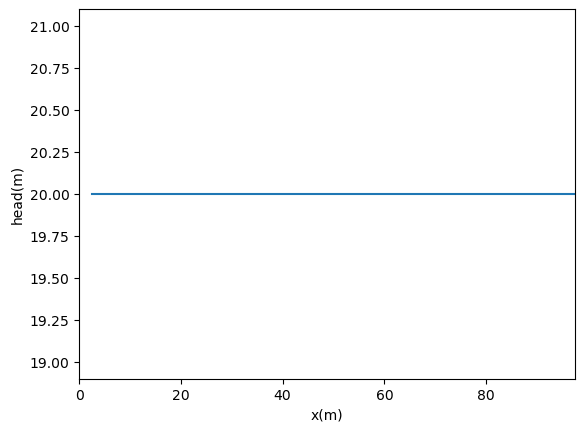

In [11]:
hds = os.path.join(ws, "B.hds")
hfile = fpu.HeadFile(hds)            # import flopy.utils as fpu
h = hfile.get_data(totim=1.0)

ax = plt.subplot(111)                     # import matplotlib.pyplot as plt            
x = C.modelgrid.xcellcenters[0]
ax.plot(x, h[0, 0, :])
ax.set_xlim(0, x.max())
ax.set_xlabel("x(m)")
ax.set_ylabel("head(m)")
plt.show()

# __Plot_02__

In [12]:
hds = bf.HeadFile(Path(ws) / f"{name}.hds")           # bf
head = hds.get_data(totim=1.0)
# head = hds.get_data(totim=times[-1])
times = hds.get_times()

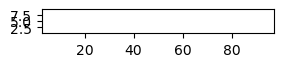

In [13]:
extent = (delr / 2.0, Lx - delr / 2.0, Ly - delc / 2.0, delc / 2.0)      # delr / 2.0  = 
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.contour(head[0, :, :], levels=np.arange(1, 10, 1), extent=extent)      # plt.tight_layout()

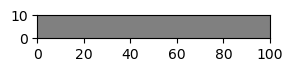

In [14]:
cbb = bf.CellBudgetFile(Path(ws) / f"{name}.cbc")                 
kstpkper_list = cbb.get_kstpkper()

frf = cbb.get_data(text="FLOW RIGHT FACE", totim=times[-1])[0]
fff = cbb.get_data(text="FLOW FRONT FACE", totim=times[-1])[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge((frf, fff, None), C, head)    

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
modelmap = flopy.plot.PlotMapView(model=C, layer=0, ax=ax)          
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid()
cs = modelmap.contour_array(head, levels=np.linspace(0, 10, 11))     
#quiver = modelmap.plot_vector(qx, qy)